# 0. Introduction: Virtual Patients

Given a set of data about a patient group, we want to produce a way of describing their distribution without revealing individual patient identities. We can do this by releasing a set of 'virtual patients' with the same statistics as the original set or, ideally, by releasing a function which describes their distribution.

I initially cover the idea Max had of using the results of a sparse GP to hide individual data points: Max suggested that inducing inputs provided through sparse gaussian processes (GPs) could be used to provide 'fake' data points, with all of the statistical and structural features of the original data. I found however that one can still infer patient values using these values. 

I then look at the result of Hall et al. 2013 in which they applied differential privacy (DP) to functions. The rest of the document looks at how to apply this method to gaussian processes.

Inducing inputs make a return later in the document: I found that inducing inputs have properties which allow much lower bounds to be placed on the added noise, allowing us to retain the utility of the function being described.

# 1. SparseGP for Privacy

## Original idea (from Max)

> In sparse GP, the prediction could be a promising part to look into, as it is a series of matrix products, which might not be unambigued. Let me discribe how the prediction works. We want to predict outputs $Y^∗$ from inputs $X^∗$, using a model trained on the data $Y$, $X$, where $X$ are the inputs and $Y$ are the outputs. In the case of sparse GP we go through so called inducing inputs, which determine the points of reference for predictions. All we need is the covariances between the inducing inputs and the inputs $K_{FU}$, the covariance within the inducing inputs $K_{UU}$. The prediction then needs the covariance between the new prediction inputs and the inducing inputs $K_{F^∗U}$. With that the prediction looks like:

$$\begin{align}
p(Y^*|X^*, X, Y) &= \int p(Y^*|U) p(U|Y) dU \\
& = \mathcal{N}(Y^*|\beta K_{F^*U} \Sigma^{-1} K_{UF^*} Y, \Lambda + K_{F^*U} \Sigma^{-1} K_{UF^*}) \\
\Sigma &= K_{UU} + \beta K_{UF} K_{FU}\\
\Lambda &= K_{FF} - K_{FU} K^{-1}_{UU} K_{UF}
\end{align}$$

> Thus, after training we could give the user the matrices

$C = \beta \Sigma^{-1} K_{UF^*} Y$,
$\Lambda$,
$\Sigma^{-1}$
$Z$

## Why sparse GP doesn't provide enough privacy

### Introduction

I was immediately concerned that outliers might still be 'tracked' by inducing inputs. Often, if there are enough 'spare' inducing inputs, an inducing input will lie immediately on top of the outlier. More in general I was concerned about whether the reduced matrix really would hide the data. Although not all inputs can be reconstructed from a low rank approximation, I thought that the uncertainty wouldn't be evenly 'spread' across the different inputs.

### Small Example

Below is an example with just 4 data points (and 3 inducing points).

I look at how easy it is to estimate the Xs given the outputs we will provided.

Populating the interactive namespace from numpy and matplotlib
warning in stationary: failed to import cython module: falling back to numpy


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f707e9dde10>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f707ea434d0>],
 'inducing_inputs': [<matplotlib.lines.Line2D at 0x7f707ea43490>]}

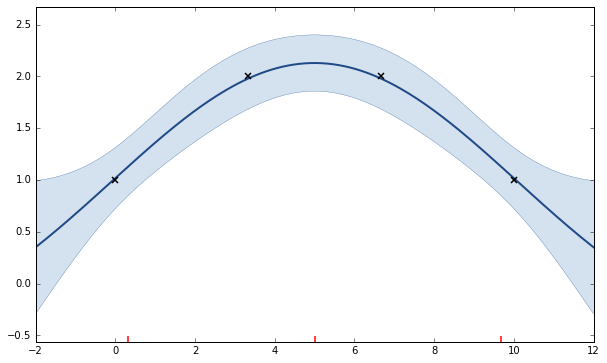

In [1]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

N = 4
M = 3
noise_var = 0.1
X = np.linspace(0,10,N)[:,None]
y = np.hstack([np.linspace(1,2,np.floor(N/2.)),np.linspace(2,1,N-np.floor(N/2.))])
y = y[:,None]
y = y

k = GPy.kern.RBF(1,lengthscale=5.,variance=19.)
Z = np.linspace(0,10,M)[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z)
m.likelihood.variance = noise_var
m.optimize()

m.plot()

### Estimating the inputs...

The plan was to provide to the user the following values:
$C$,
$\Lambda$,
$\Sigma^{-1}$ or
$Z$?

Can the user infer estimates or values of $X$ and $Y$ from these?

$C = \beta \Sigma^{-1} K_{UF} Y$

$\Sigma = K_{UU} + \beta K_{UF} K_{FU}$

The user has $\Sigma$ and can find $K_{UU}$ from Z and the kernel. So they have $\beta K_{UF} K_{FU}$.

What is $\beta$? Assume it can be estimated for now?

So they have $K_{UF} K_{FU}$, which in this case is:

In [3]:
np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

array([[  7.68807932,   8.18861109,   5.75716185],
       [  8.18861109,  10.0254779 ,   8.18861109],
       [  5.75716185,   8.18861109,   7.68807932]])

**If** they can factorise this (this is the big question, that we'll look at in a second). They'll have:

In [4]:
K_uf = m.kern.K(m.Z, m.X)
print K_uf

[[ 1.84774946  1.64862501  1.11146687  0.56619626]
 [ 1.34975008  1.78631287  1.78631287  1.34975008]
 [ 0.56619626  1.11146687  1.64862501  1.84774946]]


If they know this matrix, they'll be able to easily infer X, as they know Z and the kernel.

In [9]:
Z

array([[  0.],
       [  5.],
       [ 10.]])

In [6]:
m.rbf.lengthscale.values

array([ 6.29677512])

So can we distinguish Z locations from $K_{UF}$ matrix.

If we know the locations of the inducing inputs and we know the covariance between the inducing inputs and the original inputs, then we can work out the locations of the original inputs, as illustrated below. The three curves are the covariance functions surrounding each inducing input, the horizontal lines are the covariances from the $K_{uf}$ matrix. To find the locations of the inputs is merely a matter of finding where those values $K_{uf}$ equal the covariance functions around each inducing input.

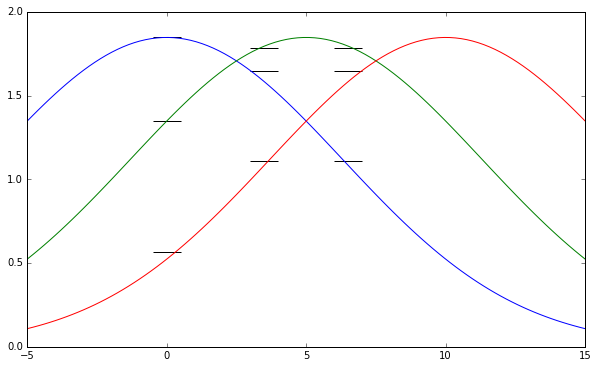

In [8]:
dom = np.linspace(-5,15,100)
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[0])**2/m.rbf.lengthscale.values**2))
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[1])**2/m.rbf.lengthscale.values**2))
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[2])**2/m.rbf.lengthscale.values**2))
plt.hlines(K_uf[:,0],-.5,.5)
plt.hlines(K_uf[:,1],3,4)
plt.hlines(K_uf[:,2],6,7)

### Factorising the K_{UF} K_{FU} matrix

So the question now is can the $K_{UF} K_{FU}$ matrix be factorised?

It is created by the product of a pair of matrices of the form:

    [      ] x [ ] = [ ]
               [ ]
               [ ] 
               [ ]
               
I.e. wide x long. Which gives a smaller matrix, and loses lots of info. It seems like it should be impossible to factorise to recover the original values. To help understand: Imagine the most extreme example in which the row matrix is $1 \times N$ and the column matrix is $N \times 1$, the output is only a single number, which we would struggle to use to reconstruct $2N$ values from. 

In [13]:
#Here's an example where we can't recover the original matrix [0,1,2], just by knowing that the sum square is 5.
import numpy as np
U = np.array([0,1,2])
np.dot(U,U.T)

5

In the example above we can't recover that the original matrix was [0,1,2].

### Outliers can be found

However, if we imagine a situation in which one of the inducing inputs was placed at the location of one of the data points, a long way from other data, then the matrix might look like:

In [14]:
#In this case, the correlation of the first inducing input with the data is [.2, .5, 0], 
#ie, it is close to the first two data points.
#The second inducing input is near the third data point, and far from the first two.

U = np.array([[.2,.5,0],[0,0,1]])
print U

[[ 0.2  0.5  0. ]
 [ 0.   0.   1. ]]


In [15]:
np.dot(U,U.T)

array([[ 0.29,  0.  ],
       [ 0.  ,  1.  ]])

We know the locations of the inducing points and so, if we know the largest covariance value that can exist for that kernel (e.g. 1) then we know that one of the original data points was at the location of the second inducing point.

### Can we guess the training inputs (m.X)?

We've seen a particular example of an outlier being identified, but what about a more typical set of data. I'm unsure how to show it analytically, but below I use a numerical optimisation method to try to find values of $X$ which fit the $K_{UF} K_{FU}$ matrix as closely as possible.

So, rather than do anything clever, I just ask scipy to find X from the matrix.

In [10]:
A = np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

import numpy as np
from scipy.optimize import minimize

def cost(B):
    B = B[:,None]
    k = m.kern.K(m.Z, B)
    
    return np.sum((A - np.dot(k,k.T))**2) #sum sqr error



X0 = np.array([9,4,2,10]) #np.linspace(0,1,N)
print cost(X0)
res = minimize(cost, X0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
guesses = np.array(res.values()[4])[:,None]
print guesses
print X

5.35222239776
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 234
         Function evaluations: 410
[[  6.66666667e+00]
 [  4.47718170e-09]
 [  3.33333333e+00]
 [  1.00000000e+01]]
[[  0.        ]
 [  3.33333333]
 [  6.66666667]
 [ 10.        ]]


Clearly it has successfully found the locations of the four data points.

This seems like a trivial example (with only 4 data points, and 3 inducing inputs there's enough dof in the covariance matrix for the information about the data to be preserved)...

### More complicated example (7 inputs, 3 inducing inputs)

To see if this is a problem for a slightly more complicated example,

we consider 7 data points and 3 inducing inputs.

Populating the interactive namespace from numpy and matplotlib
[[ 1.08467875  0.99934974  0.86911716  0.4044152   0.25225269  0.09826947
   0.05625054]
 [ 0.9861845   1.07758881  1.11145639  0.8627345   0.66601447  0.36494172
   0.24774798]
 [ 0.19096424  0.29121384  0.41919531  0.88449694  1.03576004  1.10542459
   1.04732333]]
-0.00
4.06
7.91
20.23
24.67
33.34
36.80
[[  0.]
 [  4.]
 [  8.]
 [ 20.]
 [ 25.]
 [ 33.]
 [ 37.]]
Note that some of the results were estimated, others were not. Those points nearest the inducing inputs were most vulnerable (makes sense?)
  Index  |  sparse_gp.inducing_inputs  |  Constraint  |   Prior   |  Tied to
  [0 0]  |                 -3.6807574  |              |           |    N/A    
  [1 0]  |                  8.1455287  |              |           |    N/A    
  [2 0]  |                  31.256583  |              |           |    N/A    


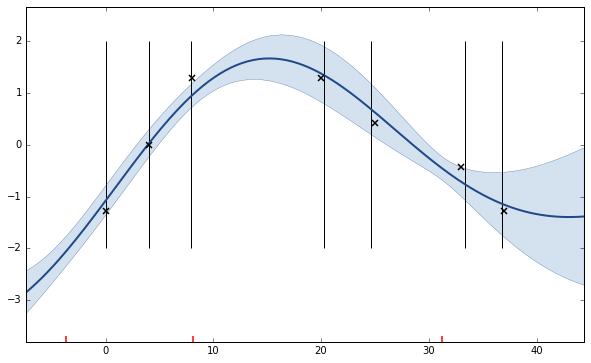

In [11]:
##Just another example, to illustrate that this can happen with more points.

%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

M = 3
X = np.array([0.,4.,8.,20.,25.,33.,37.])[:,None]
N = len(X)
y = np.hstack([np.linspace(1,2,np.floor(N/2.)),np.linspace(2,1,N-np.floor(N/2.))])
y = y - np.mean(y)
y = y / np.std(y)
y = y[:,None]
k = GPy.kern.RBF(1) #,lengthscale=5.,variance=19.)
Z = np.linspace(0,30,M)[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z.copy())

m.likelihood.variance = 0.01
m.likelihood.fix()
m.kern.lengthscale = 20
m.optimize()
m.plot()
print m.kern.K(m.Z, m.X)

A = np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

import numpy as np
from scipy.optimize import minimize

def cost(B):
    B = B[:,None]
    k = m.kern.K(m.Z, B)
    
    return np.sum((A - np.dot(k,k.T))**2) #sum sqr error

X0 = np.linspace(0,30,N)
res = minimize(cost, X0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True, 'maxfev':10000})
guesses = np.array(res.values()[4])[:,None]
for g in guesses:
    print "%0.2f" % g
print X
print "Note that some of the results were estimated, others were not. Those points nearest the inducing inputs were most vulnerable (makes sense?)"
print m.Z
plt.vlines(guesses,-2,2)

In the figure above the vertical lines are the locations the search guessed the data points to be. The crosses are the inputs' actual locations. Three data points were estimated to within 0.1 of their actual location and the rest were within 0.35, using just the three inducing inputs (indicated at the bottom of the image).

In summary, the $K_{fu} K_{uf}$ matrix can leak information about the locations of the data points, even when there are many more inputs than inducing points.

## Summary: How to provide privacy?

There are two problems the above result causes:

1. we can estimate the values of X themselves.
2. we can estimate the values of Y. This will still be uncertain as they will have confidence intervals surrounding them.

How to fix?

 - Move the values of the training data (add noise to X or Y)
 - Modify the $K_{uf}$ matrix (add noise there)
 - Move the positions of the inducing inputs after $K_{uf}$ is generated.
 
None of these seem ideal. I originally felt that adding noise to the matrix might provide the most powerful method.

The key problem is that by not using a framework (such as differential privacy) **we don't have any guarantees of privacy**.

For the rest of this work I look at how to apply differential privacy to our Gaussian Process. Most of the work has already been done for me through the paper by Hall et al. (2013).

# 2. Differential Privacy and GPs, making the inputs private (first attempt)

We are trying to produce a function (or functional) which describes the distribution of data in some private database D. We could use a Gaussian Process to model this data, however earlier notes suggest that, even using inducing points, we can't immediately remove knowledge of the data. However, we could add noise to the data or the function.

The paper "Differential Privacy for Functions" (Hall et al.) offers a method for adding noise to an arbitrary function $f$.

> Using the notation $K_x = K(x, . )$
>
> For two functions $f = \sum^n_{i=1} \theta_i K_{x_i}$ and $g = \sum^m_{j=1} \xi_j K_{y_j}$
> the inner product is given by:
>
> $$\left< f, g \right>_H = \sum_{i=1}^n \sum_{j=1}^m \theta_i \xi_j K(x_i, y_j)$$
>
> and the corresponding norm of $f$ is $||f||_H = \sqrt{ \left< f, f \right>_H }$

> For $f \in H$ where H is the RKHS corresponding to the kernel K, and for any finite sequence $x_1...x_n$ of distinct points in T, we have:

> $||K^{-1/2} f|| \leq ||f||_H$
>
> So the release of:
>
> $\hat{f_D} = f_D + {{\Delta c(\beta)} \over \alpha} G$
>
> is $(\alpha, \beta)$-DP whenever:
>
> $\Delta \geq sup_{D \sim D'} ||f_D - f_{D'}||_H$
>
> **When $G$ is the sample path of a Gaussian process having mean zero and covariance function K, given by the reproducing kernel of H.**

In summary we can make a function private by adding a sample from a Gaussian Process (with kernel equal to the GP we're trying to make private), scaled by a constant.

## Applying this to GPs

In the paper Hall applies this to Kernel Density Estimation. To make our problem more like that, we can use the representer theorem to write the mean function of the GP in a similar form (sum of [weighted] kernels).

### Representer theorem

The mean of the posterior is expressed as:

$$\bar{f_*} = \mathbf{k_*^\top} K^{-1} \mathbf{y}$$

Which can be written as a summation,

$$\bar{f_*} = \sum_{i=1}^N a_i k(\mathbf{x}, \mathbf{x}_i)$$

where $\mathbf{a} = K^{-1} \mathbf{y}$

### Reiteration

How does this help us apply differential privacy?

Section 4.1 of 'Differential Privacy for Functions' provides a method for adding gaussian process samples (as noise) to a function.

I've covered most of the important steps from the paper below, while leaving out the proofs.

We again consider two datasets, which differ in their last value, $y_n$.

We express our posterior estimate of the mean as:

$$f_D(x) = \sum_{i=1}^n a_i k(\mathbf{x},\mathbf{x}_i)$$

where $n$ is the number of elements in $\mathbf{x}$, and $\mathbf{a} = K^{-1} \mathbf{y}$

### Detour to the paper

First I consider the solution in the paper and explain it in more detail, and then I'll look at how to make it applicable to our problem.

For the example in the paper (standard kernel density estimation), the function $f_D(x)$ is:

$$f_D(x) = C \sum_{i=1}^n k(x,x_i)$$

Where $C$ is a normalisation constant.

In the paper, the sensitivity $\Delta$ must be defined to be greater or equal to the distance between $f_D$ and $f_D'$, i.e. $\Delta \geq sup_{D \sim D'} ||f_D - f_D'||_H$.

We want to put an upper bound therefore on $||f_D - f_D'||$.

#### The expression for $f_D(x) - f_D'(x)$

$$f_D(x) - f_D'(x) = C \sum_{i=1}^n k(x,x_i) - C \sum_{i=1}^n k(x,x'_i)$$

when $i \neq n$, $x'_i=x_i$ and the value in the sum of both $f_D$ and $f_D'$ are equal and cancel out. This leaves just the term in the summation when $i=n$.

$$f_D(x) - f_D'(x) = C k(x,x_n) - C k(x,x_n')$$

### Detour to RKHS

What is $||f_D - f_D'||$?

The norm of $g$ is defined to be:

$||g|| = \sqrt{\left< g,g \right>}$

Substituting in our expression:

$||f_D - f_D'||^2 = \left< C k(x,x_n) - C k(x,x_n'), C k(x,x_n) - C k(x,x_n') \right>$

We can use the linear property to 'factorise' the inner product:

$||f_D - f_D'||^2 = \left< C k(x,x_n), C k(x,x_n) \right> - \left< C k(x,x_n), C k(x,x_n') \right> - \left< C k(x,x_n'), C k(x,x_n) \right> + \left< C k(x,x_n'), C k(x,x_n') \right>$

Note that the symmetry property of inner products means the two middle terms are equal. The linear property means we can move the $C$ terms out of the inner products.

$||f_D - f_D'||^2 = C^2 \Big[ \left< k(x,x_n), k(x,x_n) \right> - 2 \left< k(x,x_n), k(x,x_n') \right>  + \left< k(x,x_n'), k(x,x_n') \right> \Big]$

We now use the magic of **Reproducing Kernel Hilbert Spaces**

We can consider the kernel $k(.,x_n)$ to be a functional, returning a different function, depending on the value of $x$. In particular we can write a kernel $k(x,x_n)$ (wrt this free variable $x$) as $k_{x_n}$. So $k_{x_n}(x) = k(x,x_n)$.

The RKHS property says that:

$\left< k_x, k_y \right>_H = k(x,y)$

So we can write $\left< k(x,x_n), k(x,x_n) \right>$ as:

$$\left< k(x,x_n), k(x,x_n) \right> = \left< k_{x_n}, k_{x_n} \right>$$

which we can write using properties of RKHS as:

$$\left< k_{x_n}, k_{x_n} \right> = k(x_n,x_n)$$

So using the same logic to the other terms in the earlier expression;

$$||f_D - f_D'||^2 = C^2 \Big[ k(x_n,x_n) - 2 k(x_n, x_n')  + k(x_n', x_n') \Big]$$

### Back to the paper...

The remaining parts of the paper are quite simple,

The expression $k(x_n,x_n) - 2 k(x_n, x_n')  + k(x_n', x_n')$ is upper bounded by 2 (as each kernel $\leq$ 1).

This means that $||f_D - f_D'||^2 \leq 2 C^2$

This allows us to pick a value for $\Delta = C \sqrt{2}$ which scales the sample drawn from the gaussian process.

### Back to our problem

Can we apply this same logic to our own problem?

We noted that the mean of the GP can be expressed as follows:

$$f_D(x) = \sum_{i=1}^n a_i k(\mathbf{x},\mathbf{x}_i)$$

where $\mathbf{a} = K^{-1} \mathbf{y}$

So following the logic of above,

$$f_D(\mathbf{x}) - f_D'(\mathbf{x}) = \sum_{i=1}^n a_i k(\mathbf{x},\mathbf{x}_i) - \sum_{i=1}^n a'_i k(\mathbf{x},\mathbf{x}'_i)$$

The immediate problem is that $a_i \neq a'_i$ (for $i \neq n$). So we can't cancel these elements, as Hall did in the kernel density estimation example. In other words the movement of one input causes a change to every term in the inverse covariance matrix.

If we left them in, what do we get?

$$f_D(\mathbf{x}) - f_D'(\mathbf{x}) = \sum_{i=1}^n a_i k(\mathbf{x},\mathbf{x}_i) - a'_i k(\mathbf{x},\mathbf{x}'_i)$$

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 = \left< \sum_{i=1}^n a_i k(\mathbf{x},\mathbf{x}_i) - a'_i k(x,x'_i), \sum_{i=1}^n a_i k(x,x_i) - a'_i k(x,x'_i) \right>$$

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j \left< k_{\mathbf{x}_i}, k_{\mathbf{x}_j}\right> - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j \left< k_{\mathbf{x}_i}, k_{\mathbf{x}'_j}\right> + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j \left< k_{\mathbf{x}'_i}, k_{\mathbf{x}'_j}\right>$$

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j k(\mathbf{x}_i, \mathbf{x}_j) - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j k(\mathbf{x}_i, \mathbf{x}'_j) + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j k(\mathbf{x}'_i, \mathbf{x}'_j)$$

For our first attempt we simply provided the following bound on the values of the kernels: We note that the kernels are all $\leq 1$, so:

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 \leq \sum_{i=1}^n \sum_{j=1}^n a_i a_j - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j$$


$$||f_D(x) - f_D'(x)||^2 \leq \sum \mathbf{a} \mathbf{a^\top} - 2 \sum \mathbf{a} \mathbf{a'}^{\top} + \sum \mathbf{a'} \mathbf{a'}^\top$$

where these summations are over all elements in the matrix.

$$||f_D(x) - f_D'(x)||^2 \leq \mathbf{1} \mathbf{a} \mathbf{a^\top} \mathbf{1}^\top - 2 \mathbf{1} \mathbf{a} \mathbf{a'}^{\top} \mathbf{1}^\top + \mathbf{1} \mathbf{a'} \mathbf{a'}^\top \mathbf{1}^\top$$

The middle term's in the opposite direction, so we'll remove it.

$$||f_D(x) - f_D'(x)||^2 \leq \mathbf{1} \mathbf{a} \mathbf{a^\top} \mathbf{1}^\top + \mathbf{1} \mathbf{a'} \mathbf{a'}^\top \mathbf{1}^\top$$

Let $G = K^{-1}$

$\Delta^2 \leq \mathbf{1 (a a^\top + a' a'^\top) 1^\top}$

substituting in for $\mathbf{a}$:

$\Delta^2 \leq \mathbf{1} \Big(G \mathbf{y} (G \mathbf{y})^\top + G' \mathbf{y} (G' \mathbf{y})^\top \Big) 1^\top$

$\Delta^2 \leq \mathbf{1} \Big(G \mathbf{y} \mathbf{y}^\top G^\top + G' \mathbf{y} \mathbf{y}^\top G'^\top \Big) 1^\top$

$\Delta^2 \leq \mathbf{1} (G + G') (\mathbf{y} \mathbf{y}^\top) (G + G')^\top 1^\top$

$\Delta^2 \leq \mathbf{1} (G + G') \mathbf{y} \mathbf{y}^\top (G + G')^\top 1^\top$

Note that $ \mathbf{1} (G + G') \mathbf{y}$ is scalar, and identical to the second half, leaving:

$\Delta^2 \leq \Big(\mathbf{1} (G + G') \mathbf{y} \Big)^2$

$\Delta \leq \mathbf{1} (G + G') \mathbf{y}$

$\Delta \leq \mathbf{1} (K^{-1} + K'^{-1}) \mathbf{y}$

Unfortunately this doesn't look any more generalisable. For a given pair of inverse covariance matrices, we have this bound on $\Delta$.

> Thought: Could we use this still to select $\Delta$. One needs to be careful that the value of $\Delta$ doesn't reveal information about the underlying data. A later section in the paper (4.1.2 Private Choice of Bandwidth) handles a similar problem in selecting a value of H. Could we apply a similar idea to the selection of $\Delta$. We need to find a differentially private version of $\hat{\Delta}$?

## Too much noise

Can we put a bound on the values in the $K^{-1}$ matrix? After playing with examples of $K^{-1}$ (with the rbf kernel), I found that if the data is placed sufficiently far apart, an upper bound on the sum of the elements on one row of the inverse covariance matrix (for the rbf kernel) is $2N$. **Not yet shown analytically.**

If $|\mathbf{y}| \leq y_{max}$ is bounded, and we also bound how close together the values of $\mathbf{x}$ can be. Then the upper bound on the $G \mathbf{y}$ result is equal to $N y_{max}$.

Substituting this in

$\Delta \leq 4 N y_{max}$

For example, $N = 10$ and $y_{max}=10$.

We must ensure that $x$ is at least a certain distance apart (to be decided).

Substituting into our expression for $\Delta$:

$\Delta \leq 4 \times 10 \times 10 = 400$

This scale is almost certainly too large to be of use.

In part 2 we look at an improved bound and how inducing inputs can be used to further reduce the sensitivity.